## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [1]:
import os
import keras

# 防止調用 GPU 報錯：Blas GEMM launch failed
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC' #A "Best-fit with coalescing" algorithm, simplified from a version of dlmalloc.
config.gpu_options.per_process_gpu_memory_fraction = 0.9 #佔用 GPU 多少比例的記憶體資源
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
        x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95
SAVE_BEST_ONLY = [True, False]

In [8]:
# 載入 Callbacks
from keras.callbacks import ModelCheckpoint
results = {}
for sbo in SAVE_BEST_ONLY:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with save best only = %s" % str(sbo))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()

    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    # 載入 Callbacks
    model_ckpt = ModelCheckpoint(filepath="./Day_086_HW_"+str(sbo)+".h5",  # 儲存路徑
                                 monitor="val_loss",           # 監控數據
                                 save_best_only=sbo,           # (=True) 只保存在验证集上性能最好的模型
                                 verbose=1                     # 印出資訊
                                )


    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[model_ckpt]
             )

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]

    exp_name_tag = "sbo-%s" % str(sbo)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}  

Experiment with save best only = True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 12

50000/50000 [==============================] - 3s 53us/step - loss: 0.8042 - acc: 0.7360 - val_loss: 1.5177 - val_acc: 0.4880

Epoch 00033: val_loss did not improve from 1.45154
Epoch 34/50
50000/50000 [==============================] - 2s 50us/step - loss: 0.7862 - acc: 0.7444 - val_loss: 1.5174 - val_acc: 0.4921

Epoch 00034: val_loss did not improve from 1.45154
Epoch 35/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.7668 - acc: 0.7532 - val_loss: 1.5321 - val_acc: 0.4945

Epoch 00035: val_loss did not improve from 1.45154
Epoch 36/50
50000/50000 [==============================] - 2s 48us/step - loss: 0.7451 - acc: 0.7612 - val_loss: 1.5186 - val_acc: 0.4923

Epoch 00036: val_loss did not improve from 1.45154
Epoch 37/50
50000/50000 [==============================] - 2s 49us/step - loss: 0.7286 - acc: 0.7675 - val_loss: 1.5534 - val_acc: 0.4845

Epoch 00037: val_loss did not improve from 1.45154
Epoch 38/50
50000/50000 [==============================] - 2s 

50000/50000 [==============================] - 4s 72us/step - loss: 1.1143 - acc: 0.6184 - val_loss: 1.4753 - val_acc: 0.4830

Epoch 00018: saving model to ./Day_086_HW_False.h5
Epoch 19/50
50000/50000 [==============================] - 4s 72us/step - loss: 1.0911 - acc: 0.6275 - val_loss: 1.4746 - val_acc: 0.4843

Epoch 00019: saving model to ./Day_086_HW_False.h5
Epoch 20/50
50000/50000 [==============================] - 4s 74us/step - loss: 1.0696 - acc: 0.6359 - val_loss: 1.4750 - val_acc: 0.4910

Epoch 00020: saving model to ./Day_086_HW_False.h5
Epoch 21/50
50000/50000 [==============================] - 4s 71us/step - loss: 1.0467 - acc: 0.6446 - val_loss: 1.4768 - val_acc: 0.4904

Epoch 00021: saving model to ./Day_086_HW_False.h5
Epoch 22/50
50000/50000 [==============================] - 4s 71us/step - loss: 1.0261 - acc: 0.6528 - val_loss: 1.4645 - val_acc: 0.4913

Epoch 00022: saving model to ./Day_086_HW_False.h5
Epoch 23/50
50000/50000 [==============================] - 3s 

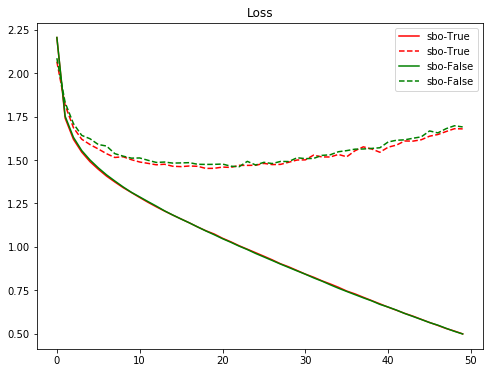

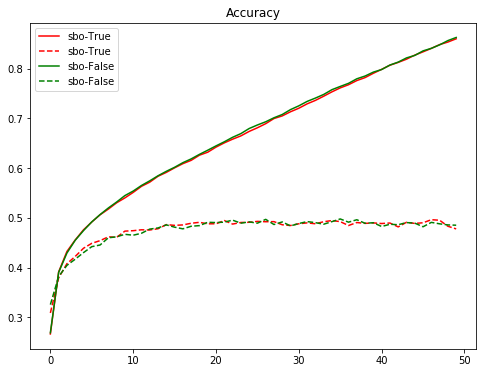

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

## 作業 2 : 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [10]:
# Load back
from keras.models import load_model
new_model = load_model("./Day_086_HW_True.h5")

print('------------------------------\nOriginal\n------------------------------')
print(model.evaluate(x_test, y_test))
print('------------------------------\nRestore\n------------------------------')
print(new_model.evaluate(x_test, y_test))

------------------------------
Original
------------------------------
10000/10000 [==============================] - 1s 76us/step
[1.6905994438171388, 0.4851]
------------------------------
Restore
------------------------------
10000/10000 [==============================] - 1s 92us/step
[1.451542737388611, 0.4909]
